In [1]:
import librosa
import numpy as np
import sys
sys.path.append('../script')

In [2]:
import get_dataset as ds
import constants
speech_spec, dialects = ds.load_features(feature_name='spectrogram')

Getting Ngadas: Marsam.wav 0.0
Getting Ngadas: Mas_Tom_Ngadas_201102.wav 0.0
Getting Banten: JWBP-20121229-A.wav 0.0
Getting Banten: JWBA-20100703-a.wav 0.0
Getting Banten: JWB-Banten_9.wav 0.0
Getting Banten: banten-2010-07-02-a.wav 0.0
Getting Banten: JWB-20090125.wav 0.0
Getting Banten: JWBP-20121229-B.wav 0.0
Getting Banten: JWB-Banten_10.wav 0.0
Getting Banten: JWB-20090126.wav 0.0
Getting Banten: JWB-20090116.wav 0.0
Getting Banten: JWB-Banten20100605-B.wav 0.0
Getting Banten: JWB-Banten_1.wav 0.0
Getting Banten: JWB-Banten_6.wav 0.0
Getting Banten: JWBA-20100703-b.wav 0.0
Getting Banten: JWB-Banten_4.wav 0.0
Getting Banten: JWB-20090117.wav 0.0
Getting Banten: JWB-20090118.wav 0.0
Getting Banten: JWB-Banten_8.wav 0.0
Getting Banten: JWB-20090131.wav 0.0
Getting Banten: JWB-20090130.wav 0.0
Getting Banten: JWB-Banten_11.wav 0.0
Getting Banten: JWB-Banten_5.wav 0.0
Getting Banten: JWB-20090123.wav 0.0
Getting Banten: JWB-20090124.wav 0.0
Getting Banten: JWB-20090127.wav 0.0
Gettin

In [3]:
from pympler.asizeof import asizeof

print('Loaded dataset size in RAM: {a:2.2f}GB'.format(a=asizeof(speech_spec) / 1e9))

Loaded dataset size in RAM: 1.52GB


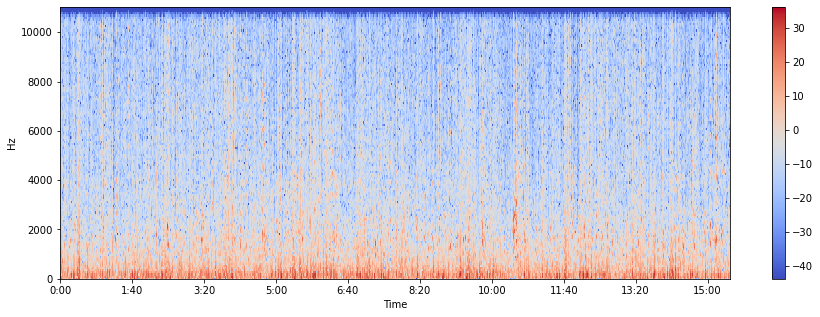

In [4]:
from matplotlib import pyplot as plt
from librosa import display

plt.figure(figsize=(15,5))
librosa.display.specshow(
    librosa.amplitude_to_db(speech_spec[0]),
    hop_length=constants.HOP_LENGTH,
    x_axis='time',
    y_axis='hz'
)
plt.colorbar()

plt.show()

In [5]:
# Window split
import preprocessing as pre

speech_spec_split = list()
dialects_split = list()

for feature, dialect in zip(speech_spec, dialects):
    temp = pre.split_window(feature)
    for w in temp:
        speech_spec_split.append(w)
        dialects_split.append(dialect)

speech_spec_split = np.array(speech_spec_split, dtype=np.float32)[:, :, :, np.newaxis]
dialects_split = np.array(dialects_split)[:, np.newaxis]

In [6]:
print("Spectrogram data shape: {}".format(speech_spec_split.shape))
print("Dialects data shape: {}".format(dialects_split.shape))

Spectrogram data shape: (38093, 128, 78, 1)
Dialects data shape: (38093, 1)


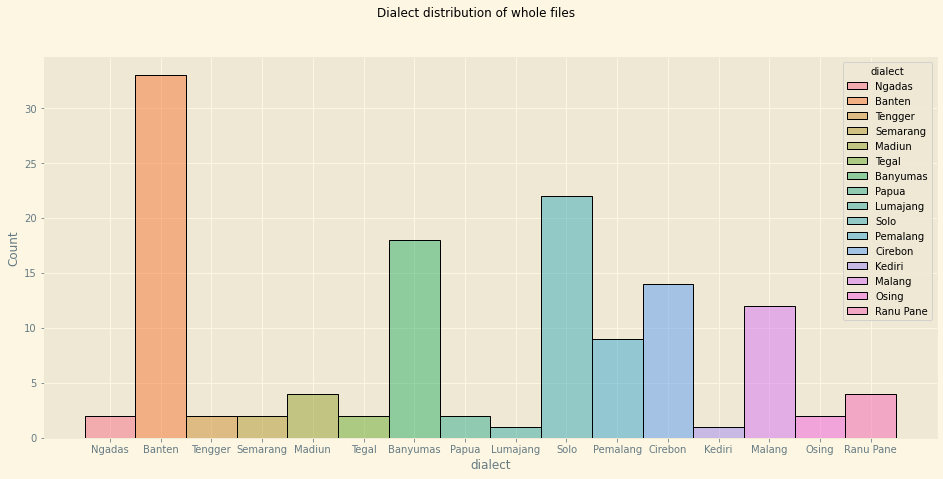

In [7]:
import pandas as pd

# Creating a dialects pandas dataframe for visualization
dialects_df = pd.DataFrame(dialects, columns=['dialect'])

# Full distribution
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('Solarize_Light2')

plt.figure(figsize=(16, 7))
plt.suptitle('Dialect distribution of whole files')
sns.histplot(dialects_df, x='dialect', hue='dialect')

plt.savefig('../visualization/dialect-distribution.png')
plt.show()

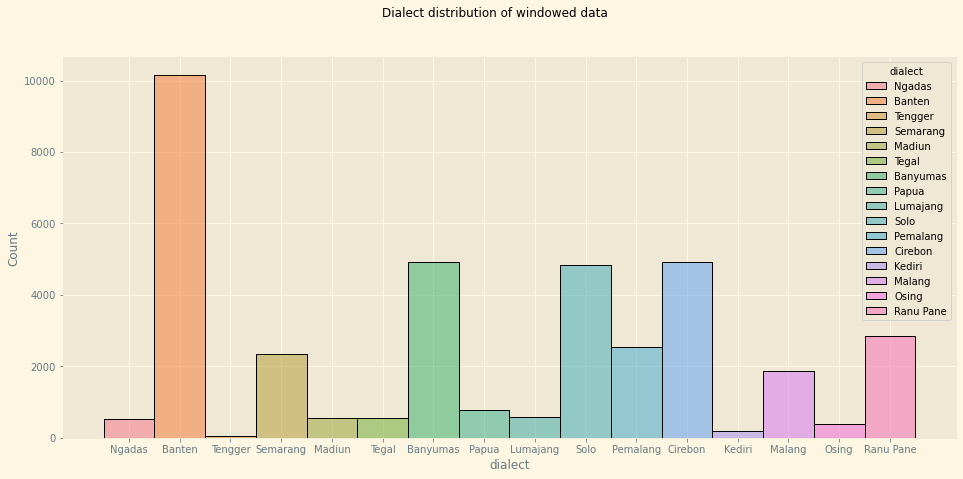

In [8]:
# Creating a dialects pandas dataframe for visualization
dialects_split_df = pd.DataFrame(dialects_split, columns=['dialect'])

# Windowed distribution

plt.figure(figsize=(16, 7))
plt.suptitle('Dialect distribution of windowed data')
sns.histplot(dialects_split_df, x='dialect', hue='dialect')

plt.savefig('../visualization/dialect-distribution-windowed.png')
plt.show()

In [9]:
# Cleanup
import gc

# Dataframes
del dialects_df, dialects_split_df

# For loop variables
del temp, dialect, feature, w 

# Initial variables
del dialects, speech_spec

gc.collect()

40358

In [10]:
# One-hot encoding of dialects
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(handle_unknown='error')
onehot.fit(dialects_split)

dialects_onehot = onehot.transform(dialects_split).toarray().tolist()
print(dialects_onehot[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
from sklearn.model_selection import train_test_split

X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    speech_spec_split,
    dialects_onehot, # dialects_split,
    train_size=0.8,
    random_state=42
)

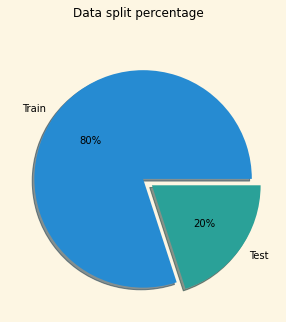

In [12]:
# Distribution of data overall

plt.figure(figsize=(5, 5))
plt.suptitle('Data split percentage')
plt.pie([X_spec_train.shape[0], X_spec_test.shape[0]], explode=[0.0, 0.1], labels=['Train', 'Test'], shadow=True, autopct='%2.f%%')

plt.show()

AttributeError: 'list' object has no attribute 'reshape'

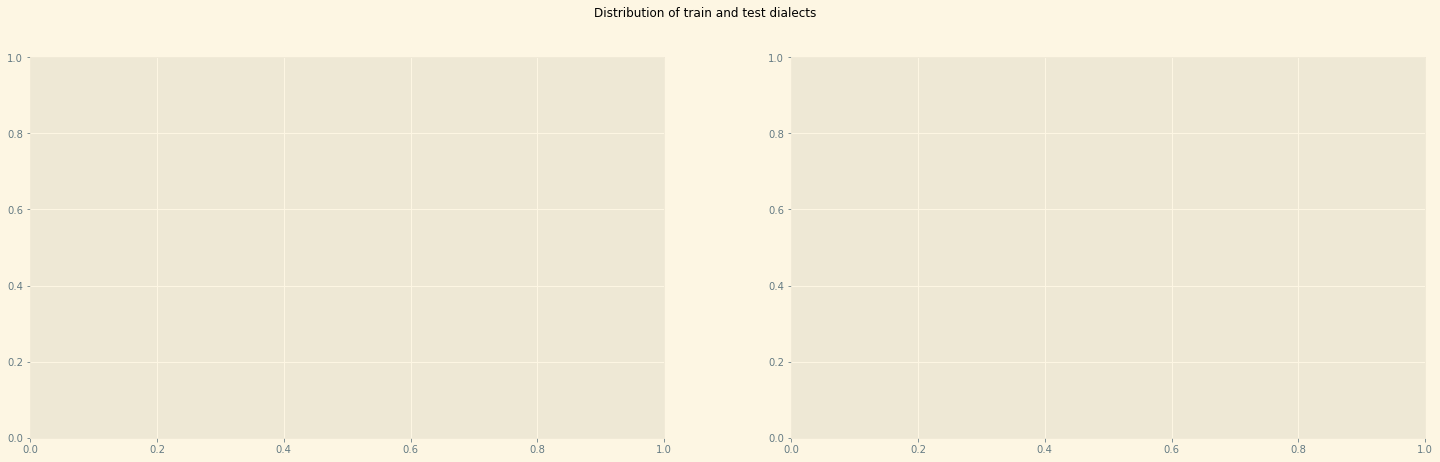

In [13]:
# Presentation of distribution
fig, ax = plt.subplots(1, 2, figsize=(25, 7))
plt.suptitle('Distribution of train and test dialects')

sns.histplot(sorted(y_train.reshape(-1)), ax=ax[0])
sns.histplot(sorted(y_test.reshape(-1)), ax=ax[1])

plt.tight_layout()
plt.savefig('../visualization/distribution-train-test.png')
plt.show()

/tmp/ipykernel_3603/2281089253.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


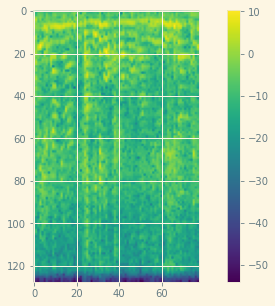

(128, 78, 1)

In [14]:
plt.figure(figsize=(10, 5))

plt.imshow(librosa.power_to_db(X_spec_train[0]))
plt.colorbar()
plt.show()

X_spec_train[0].shape

In [15]:
# One-hot transformation of labels

y_train = onehot.transform(y_train.reshape((-1, 1))).toarray()
y_test = onehot.transform(y_test.reshape((-1, 1))).toarray()

In [16]:
# Clearing memory.

del fig, ax, speech_spec_split, dialects_split
gc.collect()

17603

In [17]:
import tensorflow as tf

# Checking for GPU availability. If shown none, set up CUDA+cuDNN
tf.config.list_physical_devices('GPU')

2022-01-26 13:23:10.713989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 13:23:10.760721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 13:23:10.760957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
tf.keras.backend.clear_session()

def create_model(feature='spec', arch='cnn'):
    """
    Creates a TensorFlow model.
    :param feature: Audio feature used. Defaults to Mel spectrogram
    :param arch: Neural network architecture used. Defaults to CNN.
    :return: tensorflow.keras.Model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, input_shape=(128, 78, 1)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.softmax)
    ])
    # Input
    # if feature == 'mel_spec':
    #     model.add(tf.keras.layers.Conv2D)
    # # Arch
    # if arch == 'cnn':
    #     model.add(tf.keras.layers.Conv2D)
    return model

model_spec_cnn = create_model(feature='spec', arch='cnn')
model_spec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 76, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 38, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 36, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 8, 128)       0

2022-01-26 13:23:11.066643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 13:23:11.067548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 13:23:11.067833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 13:23:11.068044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
import tensorflow_addons as tfa

model_spec_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=16)
    ]
)

In [20]:
history = model_spec_cnn.fit(
    x=X_spec_train,
    y=y_train,
    batch_size=64,
    epochs=500,
    validation_data=(X_spec_test, y_test),
    steps_per_epoch=128,
    verbose=1
)

2022-01-26 13:23:11.985039: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217009664 exceeds 10% of free system memory.
2022-01-26 13:23:12.722315: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217009664 exceeds 10% of free system memory.


Epoch 1/500


2022-01-26 13:23:14.801622: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


128/128 [==============================] - 8s 42ms/step - loss: 1.7890 - categorical_accuracy: 0.4161 - precision: 0.7721 - recall: 0.2238 - f1_score: 0.1640 - val_loss: 1.3144 - val_categorical_accuracy: 0.5532 - val_precision: 0.7460 - val_recall: 0.4314 - val_f1_score: 0.2423
Epoch 2/500
128/128 [==============================] - 5s 36ms/step - loss: 1.1104 - categorical_accuracy: 0.6549 - precision: 0.8078 - recall: 0.5171 - f1_score: 0.3375 - val_loss: 0.9105 - val_categorical_accuracy: 0.7055 - val_precision: 0.7878 - val_recall: 0.6359 - val_f1_score: 0.3839
Epoch 3/500
128/128 [==============================] - 5s 36ms/step - loss: 0.8335 - categorical_accuracy: 0.7361 - precision: 0.8327 - recall: 0.6355 - f1_score: 0.4479 - val_loss: 0.7401 - val_categorical_accuracy: 0.7584 - val_precision: 0.8257 - val_recall: 0.7064 - val_f1_score: 0.4838
Epoch 4/500
128/128 [==============================] - 5s 38ms/step - loss: 0.6769 - categorical_accuracy: 0.7789 - precision: 0.8551 - 

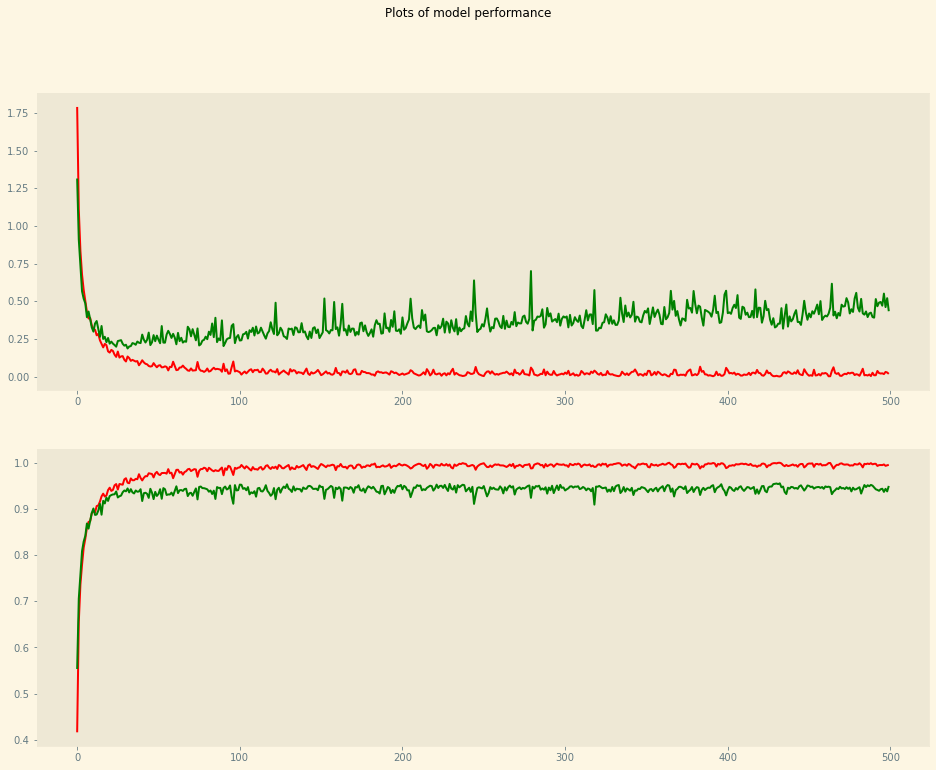

In [24]:
# Model visualisation - for now

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Plots of model performance')

ax[0].plot(history.history['loss'], 'r')
ax[0].plot(history.history['val_loss'], 'g')
ax[1].plot(history.history['categorical_accuracy'], 'r')
ax[1].plot(history.history['val_categorical_accuracy'], 'g')
ax[0].grid()
ax[1].grid()

plt.savefig('../visualization/1-model-performance-spec.png')
plt.show()

In [25]:
metrics = model_spec_cnn.evaluate(X_spec_test, y_test)
print("""Model training validation result:
Loss\t\t: {},
Accuracy\t: {},
Precision\t: {},
Recall\t\t: {},

F1 score per categories:""".format(
    metrics[0], metrics[1], metrics[2], metrics[3]
))
for i in range(len(metrics[4])):
    print('\t' + onehot.categories_[0][i] + ':', str(metrics[4][i]))

239/239 [==============================] - 2s 8ms/step - loss: 0.4342 - categorical_accuracy: 0.9495 - precision: 0.9525 - recall: 0.9475 - f1_score: 0.9276
Model training validation result:
Loss		: 0.43424519896507263,
Accuracy	: 0.9494684338569641,
Precision	: 0.9525003433227539,
Recall		: 0.947499692440033,

F1 score per categories:
	Banten: 0.98669297
	Banyumas: 0.9203268
	Cirebon: 0.9857494
	Kediri: 0.9268293
	Lumajang: 0.9072165
	Madiun: 0.8815166
	Malang: 0.8514589
	Ngadas: 0.74654377
	Osing: 0.9569892
	Papua: 0.9724138
	Pemalang: 0.9578544
	Ranu Pane: 0.90213525
	Semarang: 0.9817768
	Solo: 0.94308937
	Tegal: 0.921659
	Tengger: 1.0


In [26]:
# Saving model.
model_spec_cnn.save('../model/model_spec_cnn')
model_spec_cnn.save_weights('../model/weights/model_spec_cnn/')

INFO:tensorflow:Assets written to: ../model/model_spec_cnn/assets
